In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from mockfactory import (EulerianLinearMock, LagrangianLinearMock,
                         Catalog, BoxCatalog, RandomBoxCatalog, box_to_cutsky,
                         DistanceToRedshift, TabulatedRadialMask, HealpixAngularMask,
                         utils, setup_logging)
from cosmoprimo.fiducial import DESI
import fitsio
#import desimodel.footprint
#from astropy.table import Table, vstack
import numpy as np
from pypower import CatalogFFTPower
from time import time
setup_logging()

In [2]:
# Set up logging
setup_logging()

# Functions

In [3]:
def nbar_angular2comoving(nbar,zmin,zmax):
    # change angular density to comoving density
    cosmo = DESI()
    V23 = 4*np.pi/3 * (cosmo.comoving_radial_distance(zmax)**3 - cosmo.comoving_radial_distance(zmin)**3)
    print(f"comoving volume between {zmin} and {zmax}: {V23:.2e} Mpc3 / h3")

    # create a conversion factor so we can change nbar from deg^-2 to h^3/Mpc^3  
    Asky = 4*np.pi*(180/np.pi)**2 #41252.96124941928#41253# square deg
    conv = V23 /Asky # Mpc^3 per square deg # Mpc^3/deg^2
    print(f"conversion factor {conv:.2e}")
    
    nbar_deg = nbar # deg^-2
    nb = nbar_deg / conv
    print(f"converted nbar={nbar_deg} 1 / deg2 to nbar={nb:.2e} h3 / Mpc3")
    return nb

def nbar_angular2comoving_old(nbar,zmin,zmax):
    # change angular density to comoving density
    from astropy.cosmology import Planck18
    from astropy import units as u
    #covol = Planck18.comoving_volume(zeff)
    #print(f"comoving volume at z={zeff}: {covol:.2e}")
    V23 = Planck18.comoving_volume(zmax) - Planck18.comoving_volume(zmin)
    print(f"comoving volume between {zmin} and {zmax}: {V23:.2e}")

    # create a conversion factor so we can change nbar from deg^-2 to h^3/Mpc^3  
    Asky = 41253.*u.deg**2 # square deg
    H0 = Planck18.H0
    h = H0.value/100.
    #print(f"using h = {h}")
    conv = V23 /Asky # Mpc^3 per square deg # Mpc^3/deg^2
    print(f"conversion factor {conv:.2e}")
    
    nbar_deg = nbar/u.deg/u.deg # deg^-2
    nb = nbar_deg / conv 
    print(f"converted nbar={nbar_deg} to nbar={nb:.2e}")
    return nb.value

# Create log-normal mock
- $bias=3.0$
- $\text{boxsize} \approx 5000 \, deg^2$
- $2.75<z<3.25$
- $\bar{n}=2500\, \text{deg}^{-2}$ 
- nbar=flat

$\text{Vol}\left(2.75<z<3.25\right)/\text{deg}^2$
To change comoving density into angular density $\bar{n}*\text{Vol}/deg^2 = 2500/\text{deg}^2$

In [3]:
base_dir = "/pscratch/sd/a/arosado/mocks_tests/"

In [4]:
#-----------------------------------------------------
# Set up logging
setup_logging()
# redshift parameters
zmin = 2.75
zmax = 3.25
zeff = (zmax + zmin)/2.
print(f"zmin={zmin}, zmax={zmax}, zeff={zeff}")

# Set other parameters
bias = 3.0
boxsize = 4500 # Mpc
nmesh = 256 #512 #1024
los = 'x' # line of sight
# change angular density to comoving density
nbar = nbar_angular2comoving(2500,zmin,zmax)

zmin=2.75, zmax=3.25, zeff=3.0
comoving volume between 2.75 and 3.25: 7.92e+10 Mpc3 / h3
conversion factor 1.92e+06
converted nbar=2500 1 / deg2 to nbar=1.30e-03 h3 / Mpc3


In [5]:
%%time
seed = 42
# Loading DESI fiducial cosmology
cosmo = DESI()
power = cosmo.get_fourier().pk_interpolator().to_1d(z=zeff)
dist = cosmo.comoving_radial_distance(zeff)
dmin = cosmo.comoving_radial_distance(zmin)
dmax = cosmo.comoving_radial_distance(zmax)
boxcenter = [dist, 0, 0]
f = cosmo.sigma8_z(z=zeff,of='theta_cb')/cosmo.sigma8_z(z=zeff,of='delta_cb') # growth rate
mock = LagrangianLinearMock(power, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, seed=seed, unitary_amplitude=False)

[000011.04] [0/1] 04-07 11:22  jax._src.lib.xla_bridge   INFO     Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
[000011.04] [0/1] 04-07 11:22  jax._src.lib.xla_bridge   INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000011.04] [0/1] 04-07 11:22  jax._src.lib.xla_bridge   INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000011.04] [0/1] 04-07 11:22  jax._src.lib.xla_bridge   INFO     Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
[000011.04] [0/1] 04-07 11:22  jax._src.lib.xla_bridge   INFO     Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
[000011.04] [0/1] 04-07 11:22  jax._src.lib.

In [6]:
%%time
# this is Lagrangian bias, Eulerian bias - 1
mock.set_real_delta_field(bias=bias-1)
mock.set_analytic_selection_function(nbar=nbar)
mock.poisson_sample(seed=seed)
mock.set_rsd(f=f, los=los)
data = mock.to_catalog()
# We've got data, now turn to randoms
from mockfactory.make_survey import RandomBoxCatalog
randoms = RandomBoxCatalog(nbar=4.*nbar, boxsize=boxsize, seed=seed*2) # i put 4 as an arbitrary factor for the example

[000021.45] [0/1] 04-07 11:22  LagrangianLinearMock      INFO     Poisson sampling done, total number of objects is 118733936.
[000024.50] [0/1] 04-07 11:22  LagrangianLinearMock      INFO     Catalog produced. Assigning in cell shift.
CPU times: user 3min 20s, sys: 36.2 s, total: 3min 57s
Wall time: 3min 57s


In [20]:
dmax+0, dist + boxsize / 2.

(4540.366348854346, 6633.428771822032)

In [39]:
# Let us pick the largest (RA, Dec) range we can achieve for a maximum distance of dist + boxsize / 2.
size = 4500 
drange, rarange, decrange = box_to_cutsky(boxsize=size, dmax=cosmo.comoving_radial_distance(1.1))
#drange, rarange, decrange = box_to_cutsky(boxsize=13*1000, dmax=dist + boxsize / 2.)
print(f"largest ranges drange={drange}, rarange={rarange}, decrange={decrange}")

largest ranges drange=(0, array(2454.58491337)), rarange=(-66.44142317903301, 66.44142317903301), decrange=(-66.44142317903301, 66.44142317903301)


In [36]:
#-----------------------------------------------------
# Let us cut the above box to some geometry
#drange = [dist - (dist-dmin), dist + (dmax-dist)] # [dist - boxsize / 3., dist + boxsize / 3.]
#rarange = [10, 20]
#decrange = [20,30] #[20, 30]
drange = [dist - (dist-dmin), dist + (dmax-dist)]
rarange = [175, 290]
decrange = [-10, 70]
print(f"cuts drange={drange}, rarange={rarange}, decrange={decrange}")
# noutput = None will cut as many catalogs as possible
data_cutsky = data.cutsky(drange=drange, rarange=rarange, decrange=decrange)
randoms_cutsky = randoms.cutsky(drange=drange, rarange=rarange, decrange=decrange)                       

cuts drange=[4211.576542941594, 4540.366348854346], rarange=[10, 20], decrange=[-10, 70]
[000726.77] [0/1] 04-07 11:19  BoxCatalog                WARNING  boxsize [1000. 1000. 1000.] with margin [None, None, None] is too small for input survey geometry which requires [1314.11154136  791.43800296 5836.98246496]
[000727.06] [0/1] 04-07 11:19  RandomBoxCatalog          WARNING  boxsize [1000. 1000. 1000.] with margin [None, None, None] is too small for input survey geometry which requires [1314.11154136  791.43800296 5836.98246496]


Text(0.5, 0, 'z')

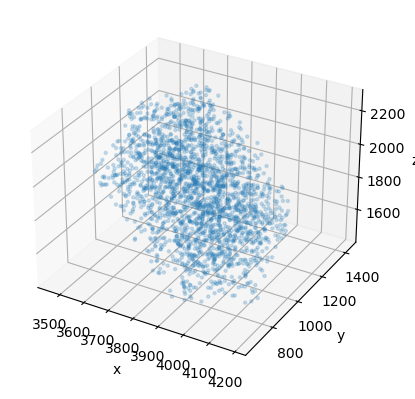

In [35]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*data_cutsky['Position'][::100].T, marker='.', alpha=0.2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [16]:
#-----------------------------------------------------
from mockfactory.make_survey import DistanceToRedshift
distance_to_redshift = DistanceToRedshift(distance=cosmo.comoving_radial_distance)
for catalog in [data, randoms]:
    catalog['Distance'], catalog['RA'], catalog['DEC'] = utils.cartesian_to_sky(catalog.position)
    catalog['Z'] = distance_to_redshift(catalog['Distance'])                               

#------------------------------------------------------
# Let us apply some redshift cuts
#from mockfactory.make_survey import TabulatedRadialMask
#mask_radial = TabulatedRadialMask(z=zslice, nbar=nbarz) 

In [ ]:
#------------------------------------------------------                               
fn = os.path.join(base_dir, 'data_'+str(bias)+'_'+str(nmesh)+'_'+str(i)+'.fits')
#mask = mask_radial(data['Z'], seed=seed)
#data[mask].write(fn)
data.write(fn)

fn = os.path.join(base_dir, 'randoms_'+str(bias)+'_'+str(nmesh)+'_'+str(i)+'.fits')
#mask = mask_radial(randoms['Z'], seed=seed)
#randoms[mask].write(fn)
randoms.write(fn)

print(f"time to finish {i}: {time() - t_ii}")

print(f"everything finished at {time() - t_i}")

Text(0.5, 0, 'z')

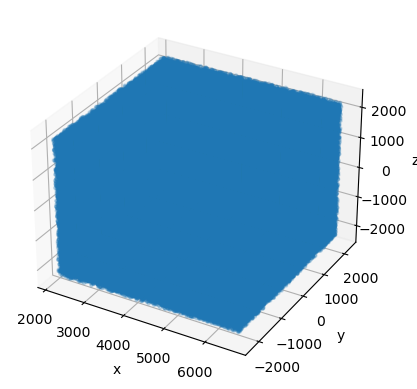

In [5]:
data = fitsio.read(f"/pscratch/sd/a/arosado/mocks_tests/data_{bias}_{nmesh}_1.fits") 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*data['Position'][::100].T, marker='.', alpha=0.2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

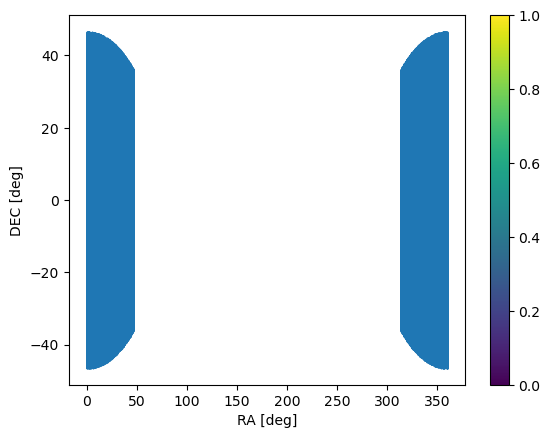

In [6]:
ra,dec = data['RA'], data['DEC']


sc = plt.scatter(ra,dec,s=0.2)
#sc = plt.scatter(ra,dec,c=sys,s=0.2)
plt.colorbar(sc)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.show()

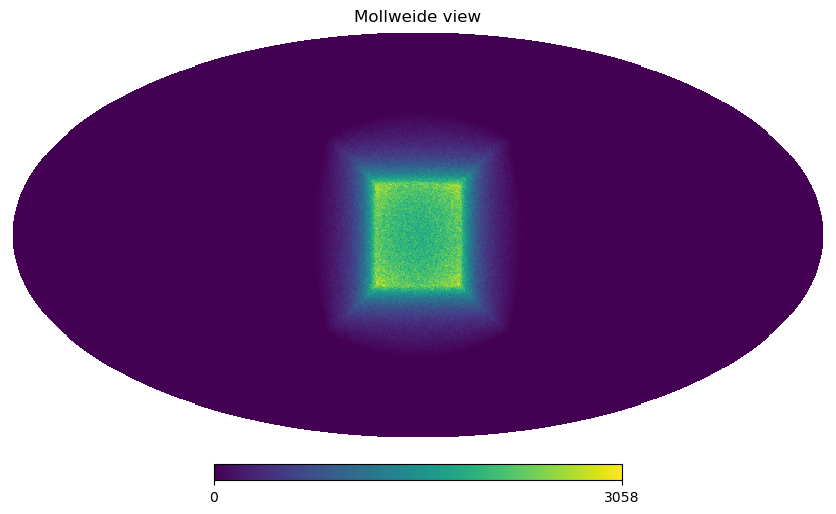

In [9]:
import healpy as hp
def hpixsum(nside, ra, dec, weights=None):
    hpix = hp.ang2pix(nside, np.radians(90 - dec), np.radians(ra))
    npix = hp.nside2npix(nside)
    weight_hp = np.bincount(hpix, weights=weights, minlength=npix)
    return weight_hp

nside = 256
data_hpmap = hpixsum(nside,data['RA'],data['DEC'])
hp.mollview(data_hpmap)

In [6]:
nmesh = 256
result = CatalogFFTPower.load(f"/pscratch/sd/a/arosado/mocks_tests/power_{bias}_{nmesh}_1.npy")
#result_test = CatalogFFTPower.load(f"/pscratch/sd/a/arosado/mocks_tests/power_test.npy")

[000023.63] [0/1] 04-05 09:53  CatalogFFTPower           INFO     Loading /pscratch/sd/a/arosado/mocks_tests/power_3.0_256_1.npy.


In [7]:
poles = result.poles
ell = 0
ax = plt.gca()
k,pk = poles(ell=ell, return_k=True, complex=False)
#k_test,pk_test = poles_test(ell=ell, return_k=True, complex=False)
ax.plot(k, k*pk, label=f'$\ell = {ell}$')
#ax.plot(k_test, k_test*pk_test, label=f'no footprint, $\ell = {ell}$')
ax.legend()
ax.grid(True)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$kP(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

/global/cfs/cdirs/desicollab/users/adematti/perlmutter/cosmodesiconda/20221205-1.0.0/code/pypower/main/lib/python3.10/site-packages/pypower/fft_power.py:1191: RuntimeWarning: divide by zero encountered in divide
  toret /= self.wnorm
/global/cfs/cdirs/desicollab/users/adematti/perlmutter/cosmodesiconda/20221205-1.0.0/code/pypower/main/lib/python3.10/site-packages/pypower/fft_power.py:1191: RuntimeWarning: invalid value encountered in divide
  toret /= self.wnorm


ValueError: Data has no positive values, and therefore can not be log-scaled.

<Figure size 640x480 with 1 Axes>

In [8]:
for i in ['']:#,'_test']:
    d = fitsio.read(f"/pscratch/sd/a/arosado/mocks_tests/data_{bias}_{nmesh}_1{i}.fits")
    r = fitsio.read(f"/pscratch/sd/a/arosado/mocks_tests/randoms_{bias}_{nmesh}_1{i}.fits")
    #kedges = np.linspace(0., 0.2, 11)
    edges={'min':0,'step':0.001}

    data_pos = [d['RA'], d['DEC'], d['Distance']]
    data_w = np.ones(d['RA'].size)

    rands_pos = [r['RA'], r['DEC'], r['Distance']]
    rands_w = np.ones(r['RA'].size)

    # pass mpiroot=0 if input positions and weights are not MPI-scattered
    result = CatalogFFTPower(data_positions1=data_pos, data_weights1=data_w, randoms_positions1=rands_pos, randoms_weights1=rands_w,
                             edges=edges, ells=(0,2,4), boxsize=5*boxsize, nmesh=nmesh, resampler='tsc', interlacing=2, los=None, position_type='rdd')
    # wavenumber array in result.poles.k
    # multipoles in result.poles.power
    result.save(f"/pscratch/sd/a/arosado/mocks_tests/power_{bias}_{nmesh}_1{i}.npy")

[000252.62] [0/1] 04-05 09:46  CatalogFFTPower           INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[256 256 256], boxsize=[10000. 10000. 10000.], boxcenter=[ 2.19492584e+03 -1.98707089e-05 -2.07151176e-05], dtype=float64).
[000252.72] [0/1] 04-05 09:46  CatalogMesh               INFO     Slab 0 ~ 4194304 / 10425794.
[000253.99] [0/1] 04-05 09:47  CatalogMesh               INFO     Painted 4194304 out of 10425794 objects to mesh.
[000253.99] [0/1] 04-05 09:47  CatalogMesh               INFO     Slab 4194304 ~ 8388608 / 10425794.
[000255.20] [0/1] 04-05 09:47  CatalogMesh               INFO     Painted 8388608 out of 10425794 objects to mesh.
[000255.20] [0/1] 04-05 09:47  CatalogMesh               INFO     Slab 8388608 ~ 12582912 / 10425794.
[000255.84] [0/1] 04-05 09:47  CatalogMesh               INFO     Painted 10425794 out of 10425794 objects to mesh.
[000256.26] [0/1] 04-05 09:47  CatalogMesh               INFO     Slab 0 ~ 4194304 / 41693091.
[000257.48] [0/1] 04-05 09

/global/cfs/cdirs/desicollab/users/adematti/perlmutter/cosmodesiconda/20221205-1.0.0/code/pypower/main/lib/python3.10/site-packages/pypower/fft_power.py:1495: RuntimeWarning: divide by zero encountered in double_scalars
  self.shotnoise = mesh1.unnormalized_shotnoise() / self.wnorm


[000317.54] [0/1] 04-05 09:48  CatalogFFTPower           INFO     ell = 0 done; 1 r2c completed
[000323.23] [0/1] 04-05 09:48  numexpr.utils             INFO     Note: detected 256 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[000323.23] [0/1] 04-05 09:48  numexpr.utils             INFO     Note: NumExpr detected 256 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[000325.51] [0/1] 04-05 09:48  CatalogFFTPower           INFO     ell = 2 done; 5 r2c completed
[000329.57] [0/1] 04-05 09:48  CatalogFFTPower           INFO     ell = 4 done; 9 r2c completed
[000330.47] [0/1] 04-05 09:48  CatalogFFTPower           INFO     Mesh calculations performed in elapsed time 14.22 s.
[000330.47] [0/1] 04-05 09:48  CatalogFFTPower           INFO     Power spectrum computed in elapsed time 77.85 s.
[000330.51] [0/1] 04-05 09:48  CatalogFFTPower           INFO     Saving /pscratch/sd/a/arosado/mocks_tests/power_3.0_256_1.npy.


/global/cfs/cdirs/desicollab/users/adematti/perlmutter/cosmodesiconda/20221205-1.0.0/code/pypower/main/lib/python3.10/site-packages/pypower/fft_power.py:2004: RuntimeWarning: invalid value encountered in double_scalars
  kwargs = {'wnorm': self.wnorm, 'shotnoise_nonorm': self.shotnoise * self.wnorm, 'attrs': self.attrs, 'mpicomm': self.mpicomm}


In [ ]:
result = CatalogFFTPower.load("/pscratch/sd/a/arosado/mocks_tests/power.npy")
result_test = CatalogFFTPower.load("/pscratch/sd/a/arosado/mocks_tests/power_test.npy")

In [5]:
from astropy.cosmology import Planck18
from astropy import units as u
covol = Planck18.comoving_volume(zeff)
print(f"comoving volume at z={zeff}: {covol:.2e}")
V23 = Planck18.comoving_volume(zmax) - Planck18.comoving_volume(zmin)
print(f"comoving volume between {zmin} and {zmax}: {V23:.2e}")

# create a conversion factor so we can change nbar from deg^-2 to h^3/Mpc^3  
Asky = 41253.*u.deg**2 # square deg
H0 = Planck18.H0
h = H0.value/100.
#print(f"using h = {h}")
conv = V23 /Asky # Mpc^3 per square deg # Mpc^3/deg^2
print(f"conversion factor {conv:.2e}")

comoving volume at z=3.0: 1.15e+12 Mpc3
comoving volume between 2.75 and 3.25: 2.59e+11 Mpc3
conversion factor 6.28e+06 Mpc3 / deg2


In [10]:
cosmo_test = DESI()
nbar_deg = 2500./u.deg/u.deg # deg^-2
nbar = nbar_deg / conv #/ cosmo_test.h**3
print(f"converted nbar={nbar_deg} to nbar={nbar:.2e}")

converted nbar=2500.0 1 / deg2 to nbar=3.98e-04 1 / Mpc3


In [ ]:
#define some parameters
bias, nbar, nmesh, boxsize,los = 3.0, nbar, 1024, 5000,'x' #adapt for your case

# David's code

In [4]:
#-----------------------------------------------------
# Set up logging
setup_logging()
zmin = 0.8
zmax = 1.1
zeff = (zmax + zmin)/2.


# to get tracer mean density from data
ttype1 = 'LRG'
filename = '/global/cfs/cdirs/desi/survey/catalogs/edav1/sv3/LSScats/'+ttype1+'_main_N_nz.txt' # For LRG only
# filename = '/global/cfs/cdirs/desi/survey/catalogs/edav1/sv3/LSScats/'+ttype1+'_N_nz.txt'
ff = np.loadtxt(filename)
zfile = ff[:,0]
nz = ff[:,3]
zcut = np.where((zfile>=zmin)&(zfile<=zmax))[0]
zslice = zfile[zcut]
nbarz = nz[zcut]
nb = np.mean(nbarz)
base_dir = "/pscratch/sd/a/arosado/mocks_tests/" # '../'
# base_dir = '/folder/of/your/choice/'  
print(f"{nb:.2e}")


#define some parameters
bias, nbar, nmesh, boxsize,los = 2.3, 1.3e-3, 256, 4500,'x' # 2.3, nb, 1024, 4500,'x' #adapt for your case

#-----------------------------------------------------

2.94e-04


In [19]:
125 * (180/np.pi * (np.cos(20/180*np.pi) -  np.cos(100/180*np.pi)))

7973.716113884109

In [19]:
#-----------------------------------------------------
t_i = time()
for i in range(1,2):
    t_ii = time()
    print(i)
    # Loading DESI fiducial cosmology
    cosmo = DESI()
    if False:
        power = cosmo.get_fourier().pk_interpolator().to_1d(z=zeff)
        dist = cosmo.comoving_radial_distance(zeff)
        dmin = cosmo.comoving_radial_distance(zmin)
        dmax = cosmo.comoving_radial_distance(zmax)
        f = cosmo.sigma8_z(z=zeff,of='theta_cb')/cosmo.sigma8_z(z=zeff,of='delta_cb') # growth rate
        boxcenter = [dist, 0, 0]
        mock = LagrangianLinearMock(power, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, seed=None, unitary_amplitude=False)
        # this is Lagrangian bias, Eulerian bias - 1
        mock.set_real_delta_field(bias=bias-1)
        mock.set_analytic_selection_function(nbar=nbar)
        mock.poisson_sample(seed=None)
        mock.set_rsd(f=f, los=los)
        data = mock.to_catalog()
        # We've got data, now turn to randoms
        from mockfactory.make_survey import RandomBoxCatalog
        randoms = RandomBoxCatalog(nbar=4.*nbar, boxsize=boxsize, seed=None) # i put 4 as an arbitrary factor for the example

    #-----------------------------------------------------
    zmin,zmax,zeff = 2.75,3.25,3.0
    dist = cosmo.comoving_radial_distance(zeff)
    dmin = cosmo.comoving_radial_distance(zmin)
    dmax = cosmo.comoving_radial_distance(zmax)
    # Let us cut the above box to some geometry
    #drange = [dist - size/3., dist + size/3.]
    drange = [dmin,dmax]#[dist - (dist-dmin), dist + (dmax-dist)]
    rarange = [200, 210]
    decrange = [-10, 0]
    boxsize = 8000
    boxcenter = [dist,0,0]
    d_fn = '/pscratch/sd/a/arosado/lognormal_mocks/data_3.0_1250.0_1024_8000.0_3.00_1_full.fits'
    r_fn = '/pscratch/sd/a/arosado/lognormal_mocks/randoms_3.0_1250.0_1024_8000.0_3.00_1_full.fits'
    data = BoxCatalog.read(d_fn, boxsize=boxsize, boxcenter=boxcenter, position='Position', velocity='Displacement')
    #from mockfactory.make_survey import RandomBoxCatalog
    randoms = RandomBoxCatalog(nbar=4.*nbar, boxsize=boxsize, seed=5000+seed_id)
    #randoms = RandomBoxCatalog.read(r_fn, boxsize=boxsize, boxcenter=boxcenter, position='Position')
    
    # noutput = None will cut as many catalogs as possible
    data = data.cutsky(drange=drange, rarange=rarange, decrange=decrange)
    randoms = randoms.cutsky(drange=drange, rarange=rarange, decrange=decrange)

    #-----------------------------------------------------
    from mockfactory.make_survey import DistanceToRedshift
    distance_to_redshift = DistanceToRedshift(distance=cosmo.comoving_radial_distance)
    for catalog in [data, randoms]:
        catalog['Distance'], catalog['RA'], catalog['DEC'] = utils.cartesian_to_sky(catalog.position)
        catalog['Z'] = distance_to_redshift(catalog['Distance'])                               

    #------------------------------------------------------
    # Let us apply some redshift cuts
    #from mockfactory.make_survey import TabulatedRadialMask
    #mask_radial = TabulatedRadialMask(z=zslice, nbar=nbarz)


    ### FOR TILE MASK
    #tls = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/tiles-DARK.fits') # change according to tracer choice
    #ind_dat = desimodel.footprint.is_point_in_desi(tls,data['RA'], data['DEC'])
    #data = data[ind_dat]
    #ind_rdm = desimodel.footprint.is_point_in_desi(tls,randoms['RA'], randoms['DEC'])
    #randoms = randoms[ind_rdm]


    #------------------------------------------------------                               

    #fn = os.path.join(base_dir, 'data_'+str(bias)+'_'+str(nmesh)+'_'+str(i)+'.fits')
    #mask = mask_radial(data['Z'], seed=None)
    #data[mask].write(fn)

    #fn = os.path.join(base_dir, 'randoms_'+str(bias)+'_'+str(nmesh)+'_'+str(i)+'.fits')
    #mask = mask_radial(randoms['Z'], seed=None)
    #randoms[mask].write(fn)
    
    print(f"time to finish {i}: {time() - t_ii}")

print(f"everything finished at {time() - t_i}")

1
time to finish 1: 512.6312971115112
everything finished at 512.6326763629913


In [3]:
cosmo = DESI()
zmin,zmax,zeff = 2.75,3.25,3.0
dist = cosmo.comoving_radial_distance(zeff)
dmin = cosmo.comoving_radial_distance(zmin)
dmax = cosmo.comoving_radial_distance(zmax)

boxsize = 8000
boxcenter = [dist,0,0]

In [4]:
r_fn = '/pscratch/sd/a/arosado/lognormal_mocks/randoms_3.0_1250.0_1024_8000.0_3.00_1_full.fits'
randoms = RandomBoxCatalog.read(r_fn, boxsize=boxsize, boxcenter=boxcenter, position='Position')

In [5]:
drange = [dmin,dmax]#[dist - (dist-dmin), dist + (dmax-dist)]
rarange = [200, 210]
decrange = [-10, 0]

In [6]:
randoms['Position'][:,0] += dist

In [7]:
randoms['Position'][:,0].min(),randoms['Position'][:,0].max()

(array(383.42877601460714), array(8383.428765766892))

In [8]:
%%time
randoms_cutsky = randoms.cutsky(drange=drange, rarange=rarange, decrange=decrange)

CPU times: user 2min 52s, sys: 58.3 s, total: 3min 50s
Wall time: 3min 46s


In [11]:
d_fn = '/pscratch/sd/a/arosado/lognormal_mocks/data_3.0_1250.0_1024_8000.0_3.00_1_full.fits'
data = BoxCatalog.read(d_fn, boxsize=boxsize, boxcenter=boxcenter, position='Position', velocity='Displacement')

In [12]:
%%time
data_cutsky = data.cutsky(drange=drange, rarange=rarange, decrange=decrange)

CPU times: user 1min 26s, sys: 41.6 s, total: 2min 7s
Wall time: 2min 5s


In [13]:
from pypower import CatalogMesh, MeshFFTPower, CatalogFFTPower, PowerSpectrumStatistics, utils, setup_logging
edges={'min':0,'step':0.001}

data_pos = [data_cutsky['RA'], data_cutsky['DEC'], data_cutsky['Distance']]
data_w = np.ones(data_cutsky['RA'].size)

rands_pos = [randoms_cutsky['RA'], randoms_cutsky['DEC'], randoms_cutsky['Distance']]
rands_w = np.ones(randoms_cutsky['RA'].size)

# pass mpiroot=0 if input positions and weights are not MPI-scattered
result = CatalogFFTPower(data_positions1=data_pos,  data_weights1=data_w, randoms_positions1=rands_pos, randoms_weights1=rands_w,
                         edges=edges, ells=0, boxsize=boxsize, nmesh=512, resampler='tsc', 
                         interlacing=2, los=None, position_type='rdd')

[000934.61] [0/1] 04-14 14:54  CatalogFFTPower           INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[512 512 512], boxsize=[8000. 8000. 8000.], boxcenter=[-3931.5402279  -1844.84376799  -394.07622616], dtype=float64).
[000934.80] [0/1] 04-14 14:54  CatalogMesh               INFO     Slab 0 ~ 4194304 / 124193.
[000934.90] [0/1] 04-14 14:54  CatalogMesh               INFO     Painted 124193 out of 124193 objects to mesh.
[000934.90] [0/1] 04-14 14:54  CatalogMesh               INFO     Slab 0 ~ 4194304 / 497764.
[000935.10] [0/1] 04-14 14:54  CatalogMesh               INFO     Painted 497764 out of 497764 objects to mesh.
[000935.10] [0/1] 04-14 14:54  CatalogMesh               INFO     Running interlacing at order 2.
[000936.85] [0/1] 04-14 14:55  CatalogMesh               INFO     Slab 0 ~ 4194304 / 124193.
[000936.94] [0/1] 04-14 14:55  CatalogMesh               INFO     Painted 124193 out of 124193 objects to mesh.
[000936.94] [0/1] 04-14 14:55  CatalogMesh               I

[001089.60] [0/1] 04-14 14:57  CatalogFFTPower           INFO     Loading /pscratch/sd/a/arosado/lognormal_mocks/power_1250.0_512_cubic.npy.
Shot noise is 1967.3099.
Normalization is 78.8790.


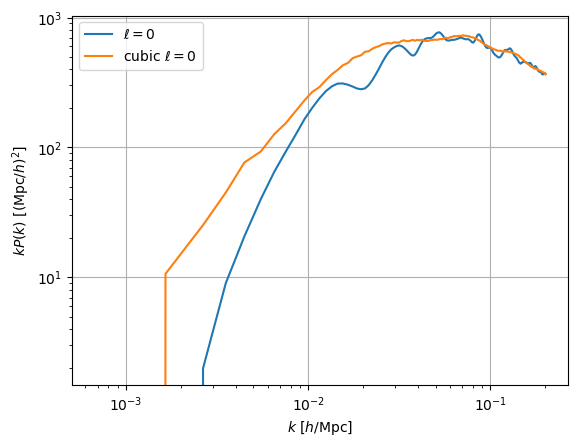

In [15]:
ax = plt.gca()
fn = '/pscratch/sd/a/arosado/lognormal_mocks/power_1250.0_512_cubic.npy'
result_cubic = CatalogFFTPower.load(fn)
poles_cubic = result_cubic.poles
poles = result.poles

print('Shot noise is {:.4f}.'.format(poles.shotnoise)) # cross-correlation, shot noise is 0.
print('Normalization is {:.4f}.'.format(poles.wnorm))
ell=0
k,pk = poles(ell=ell, return_k=True, complex=False)
ax.plot(k, k*pk, label=f'$\ell = {ell}$')
k_cubic,pk_cubic = poles_cubic(ell=ell, return_k=True, complex=False)
ax.plot(k_cubic, k_cubic*pk_cubic, label=f'cubic $\ell = {ell}$')
ax.legend()
ax.grid(True)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$kP(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

[000066.31] [0/1] 04-14 20:30  CatalogFFTPower           INFO     Loading /pscratch/sd/a/arosado/lognormal_mocks/power_512_cubic.npy.
Shot noise is 1922.2674.
Normalization is 216914.1706.


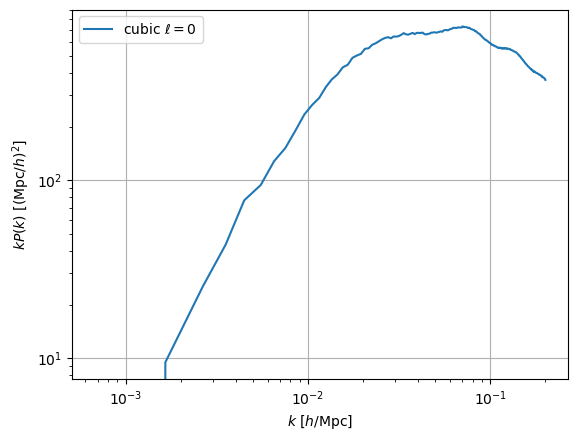

In [4]:
ax = plt.gca()
fn = '/pscratch/sd/a/arosado/lognormal_mocks/power_512_cubic.npy'
result_cubic = CatalogFFTPower.load(fn)
poles_cubic = result_cubic.poles
#poles = result.poles

print('Shot noise is {:.4f}.'.format(poles_cubic.shotnoise)) # cross-correlation, shot noise is 0.
print('Normalization is {:.4f}.'.format(poles_cubic.wnorm))
ell=0
#k,pk = poles(ell=ell, return_k=True, complex=False)
#ax.plot(k, k*pk, label=f'$\ell = {ell}$')
k_cubic,pk_cubic = poles_cubic(ell=ell, return_k=True, complex=False)
ax.plot(k_cubic, k_cubic*pk_cubic, label=f'cubic $\ell = {ell}$')
ax.legend()
ax.grid(True)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$kP(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

In [9]:
randoms_cutsky

CutskyCatalog(csize=497764, size=497764, columns=['Position', 'RA', 'DEC', 'Distance'])

In [10]:
497764/124193

4.007987567737312

In [12]:
randoms['Position'][:,0].min(),randoms['Position'][:,0].max()

(array(-3999.999995807425), array(3999.9999939448603))

In [13]:
randoms['Position'][:,1].min(),randoms['Position'][:,1].max()

(array(-3999.9999969587793), array(3999.99997455051))

In [15]:
randoms['Position'][:,2].min(),randoms['Position'][:,2].max()

(array(-3999.999992522402), array(3999.999991444705))

In [ ]:
randoms['Position'].shape

In [30]:
boxsize, boxcenter

(8000, [array(4383.42877182), 0, 0])

In [ ]:
randoms = RandomBoxCatalog(nbar=4.3e-3, boxsize=boxsize,boxcenter=boxcenter, seed=None)

In [28]:
randoms_cutsky = randoms.cutsky(drange=drange, rarange=rarange, decrange=decrange)

RandomBoxCatalog(csize=1334177661, size=1334177661, columns=['Position'])

In [5]:
r_fn = '/pscratch/sd/a/arosado/lognormal_mocks/randoms_3.0_1250.0_1024_8000.0_3.00_1_full.fits'
r = fitsio.read(r_fn)


In [9]:
d_fn = '/pscratch/sd/a/arosado/lognormal_mocks/data_3.0_1250.0_1024_8000.0_3.00_1_full.fits'
d = fitsio.read(d_fn)

In [13]:
d['Position'].shape[0]

(333568759, 3)

In [14]:
r.size/ d['Position'].shape[0]

3.9997080811755517

In [20]:
boxsize = 8000
nmesh = 512

In [25]:
data

CutskyCatalog(csize=124193, size=124193, columns=['Position', 'Displacement', 'RA', 'DEC', 'Distance', 'Z'])

In [24]:
data['RA'].min(), data['RA'].max()

(array(200.0000442697189), array(209.99993937337013))

In [21]:
randoms

CutskyCatalog(csize=0, size=0, columns=['Position', 'RA', 'DEC', 'Distance', 'Z'])

In [17]:
rands_pos

[array([]), array([]), array([])]

In [10]:
edges={'min':0,'step':0.001}

data_pos = [data['RA'], data['DEC'], data['Distance']]
data_w = np.ones(data['RA'].size)

rands_pos = [randoms['RA'], randoms['DEC'], randoms['Distance']]
rands_w = np.ones(randoms['RA'].size)

# pass mpiroot=0 if input positions and weights are not MPI-scattered
result = CatalogFFTPower(data_positions1=data_pos,  data_weights1=data_w, randoms_positions1=rands_pos, randoms_weights1=rands_w,
                         edges=edges, ells=(0,2,4), boxsize=boxsize, nmesh=nmesh, resampler='tsc', 
                         interlacing=2, los=None, position_type='rdd')

[001458.87] [0/1] 04-14 13:24  CatalogFFTPower           INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[512 512 512], boxsize=[8000. 8000. 8000.], boxcenter=[-3930.97208003 -1844.23087841  -393.69906986], dtype=float64).


/global/cfs/cdirs/desicollab/users/adematti/perlmutter/cosmodesiconda/20221205-1.0.0/code/pypower/main/lib/python3.10/site-packages/pypower/mesh.py:506: RuntimeWarning: divide by zero encountered in double_scalars
  weights += [(self.randoms_weights, -self.sum_data_weights / self.sum_randoms_weights)]


[001459.11] [0/1] 04-14 13:24  CatalogMesh               INFO     Slab 0 ~ 4194304 / 124193.
[001459.22] [0/1] 04-14 13:24  CatalogMesh               INFO     Painted 124193 out of 124193 objects to mesh.
[001459.22] [0/1] 04-14 13:24  CatalogMesh               INFO     Running interlacing at order 2.
[001461.13] [0/1] 04-14 13:24  CatalogMesh               INFO     Slab 0 ~ 4194304 / 124193.
[001461.24] [0/1] 04-14 13:24  CatalogMesh               INFO     Painted 124193 out of 124193 objects to mesh.
[001466.48] [0/1] 04-14 13:24  CatalogFFTPower           INFO     Done painting catalog 1 to mesh.
[001466.48] [0/1] 04-14 13:24  CatalogFFTPower           INFO     Using 201 k-bins between 0.000 and 0.201.
[001466.50] [0/1] 04-14 13:24  CatalogMesh               INFO     Slab 0 ~ 4194304 / 124193.
[001466.60] [0/1] 04-14 13:24  CatalogMesh               INFO     Painted 124193 out of 124193 objects to mesh.
[001466.62] [0/1] 04-14 13:24  CatalogFFTPower           INFO     Meshes prepare

/global/cfs/cdirs/desicollab/users/adematti/perlmutter/cosmodesiconda/20221205-1.0.0/code/pypower/main/lib/python3.10/site-packages/pypower/mesh.py:516: RuntimeWarning: divide by zero encountered in double_scalars
  weights += [(self.randoms_weights, self.sum_data_weights / self.sum_randoms_weights)]
/global/cfs/cdirs/desicollab/users/adematti/perlmutter/cosmodesiconda/20221205-1.0.0/code/pypower/main/lib/python3.10/site-packages/pypower/mesh.py:655: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = self.sum_data_weights / self.sum_randoms_weights
/global/cfs/cdirs/desicollab/users/adematti/perlmutter/cosmodesiconda/20221205-1.0.0/code/pypower/main/lib/python3.10/site-packages/pypower/mesh.py:656: RuntimeWarning: invalid value encountered in double_scalars
  shotnoise += alpha**2 * sum_weights2(self.randoms_positions, self.randoms_weights)


[001476.75] [0/1] 04-14 13:25  CatalogFFTPower           INFO     ell = 0 done; 1 r2c completed
[001482.17] [0/1] 04-14 13:25  numexpr.utils             INFO     Note: detected 256 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[001482.17] [0/1] 04-14 13:25  numexpr.utils             INFO     Note: NumExpr detected 256 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[001496.15] [0/1] 04-14 13:25  CatalogFFTPower           INFO     ell = 2 done; 5 r2c completed
[001524.91] [0/1] 04-14 13:25  CatalogFFTPower           INFO     ell = 4 done; 9 r2c completed
[001532.59] [0/1] 04-14 13:26  CatalogFFTPower           INFO     Mesh calculations performed in elapsed time 65.96 s.
[001532.59] [0/1] 04-14 13:26  CatalogFFTPower           INFO     Power spectrum computed in elapsed time 73.72 s.


Shot noise is nan.
Normalization is 0.0000.


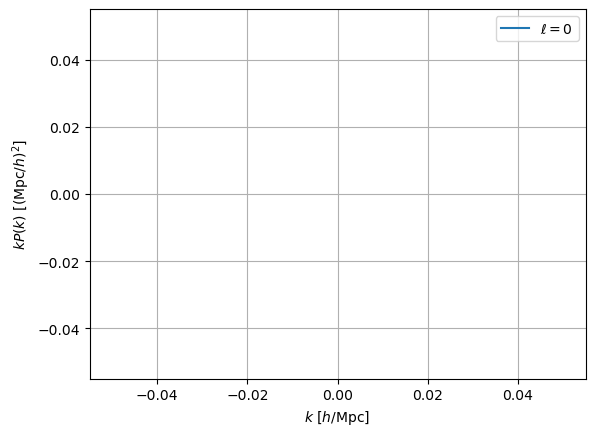

In [12]:
ax = plt.gca()
poles = result.poles
print('Shot noise is {:.4f}.'.format(poles.shotnoise)) # cross-correlation, shot noise is 0.
print('Normalization is {:.4f}.'.format(poles.wnorm))
ell=0
k,pk = poles(ell=ell, return_k=True, complex=False)
ax.plot(k, k*pk, label=f'$\ell = {ell}$')
ax.legend()
ax.grid(True)
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$kP(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

In [ ]:
for i in ['','_test']:
    d = fitsio.read(f"/pscratch/sd/a/arosado/mocks_tests/data_2.3_1024_1{i}.fits")
    r = fitsio.read(f"/pscratch/sd/a/arosado/mocks_tests/randoms_2.3_1024_1{i}.fits")
    #kedges = np.linspace(0., 0.2, 11)
    edges={'min':0,'step':0.001}

    data_pos = [d['RA'], d['DEC'], d['Distance']]
    data_w = np.ones(d['RA'].size)

    rands_pos = [r['RA'], r['DEC'], r['Distance']]
    rands_w = np.ones(r['RA'].size)

    # pass mpiroot=0 if input positions and weights are not MPI-scattered
    result = CatalogFFTPower(data_positions1=data_pos, data_weights1=data_w, randoms_positions1=rands_pos, randoms_weights1=rands_w,
                             edges=edges, ells=(0,2,4), boxsize=boxsize, nmesh=nmesh, resampler='tsc', interlacing=2, los=None, position_type='rdd')
    # wavenumber array in result.poles.k
    # multipoles in result.poles.power
    #result.save(f"/pscratch/sd/a/arosado/mocks_tests/power{i}.npy")

[000105.91] [0/1] 03-31 14:14  CatalogFFTPower           INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[1024 1024 1024], boxsize=[4500. 4500. 4500.], boxcenter=[-1059.2545697 -1244.2732221   911.366611 ], dtype=float64).
[000107.76] [0/1] 03-31 14:14  CatalogMesh               INFO     Slab 0 ~ 4194304 / 212473.
[000108.02] [0/1] 03-31 14:14  CatalogMesh               INFO     Painted 212473 out of 212473 objects to mesh.
[000108.02] [0/1] 03-31 14:14  CatalogMesh               INFO     Slab 0 ~ 4194304 / 846513.
[000108.68] [0/1] 03-31 14:14  CatalogMesh               INFO     Painted 846513 out of 846513 objects to mesh.
[000108.69] [0/1] 03-31 14:14  CatalogMesh               INFO     Running interlacing at order 2.
[000127.13] [0/1] 03-31 14:15  CatalogMesh               INFO     Slab 0 ~ 4194304 / 212473.
[000127.30] [0/1] 03-31 14:15  CatalogMesh               INFO     Painted 212473 out of 212473 objects to mesh.
[000127.31] [0/1] 03-31 14:15  CatalogMesh               I

In [ ]:
#result.save("/pscratch/sd/a/arosado/mocks_tests/power_test.npy")

In [4]:
result = CatalogFFTPower.load("/pscratch/sd/a/arosado/mocks_tests/old/power.npy")
result_test = CatalogFFTPower.load("/pscratch/sd/a/arosado/mocks_tests/old/power_test.npy")

Shot noise is 7821.3255.
Normalization is 33.9844.


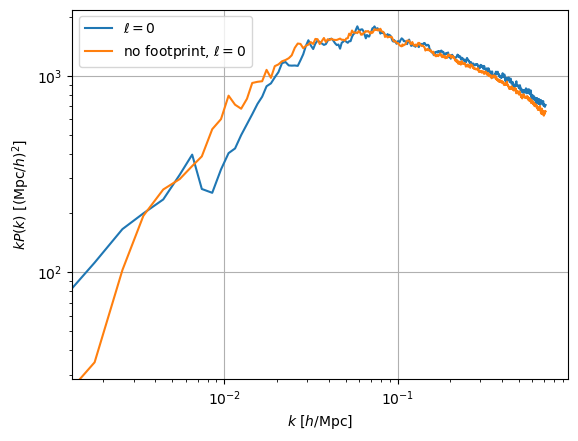

In [7]:
ax = plt.gca()
poles = result.poles
poles_test = result_test.poles
print('Shot noise is {:.4f}.'.format(poles.shotnoise)) # cross-correlation, shot noise is 0.
print('Normalization is {:.4f}.'.format(poles.wnorm))
ell=0
k,pk = poles(ell=ell, return_k=True, complex=False)
k_test,pk_test = poles_test(ell=ell, return_k=True, complex=False)
ax.plot(k, k*pk, label=f'$\ell = {ell}$')
ax.plot(k_test, k_test*pk_test, label=f'no footprint, $\ell = {ell}$')
ax.legend()
ax.grid(True)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$kP(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

Shot noise is 7821.3255.
Normalization is 33.9844.


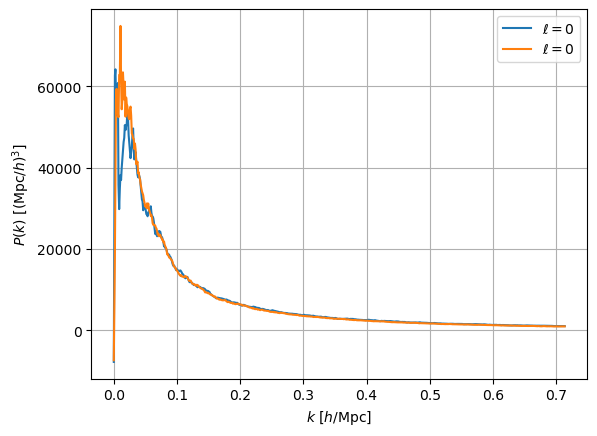

In [39]:
poles = result.poles
poles_test = result_test.poles
print('Shot noise is {:.4f}.'.format(poles.shotnoise)) # cross-correlation, shot noise is 0.
print('Normalization is {:.4f}.'.format(poles.wnorm))
ax = plt.gca()
#for ill, ell in enumerate(poles.ells):
    # Calling poles() removes shotnoise for ell == 0 by default;
    # Pass remove_shotnoise = False if you do not want to;
    # See get_power() for all arguments
ell=0
ax.plot(*poles(ell=ell, return_k=True, complex=False), label=r'$\ell = {:d}$'.format(ell))
ax.plot(*poles_test(ell=ell, return_k=True, complex=False), label=r'$\ell = {:d}$'.format(ell))
ax.legend()
ax.grid(True)
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.show()



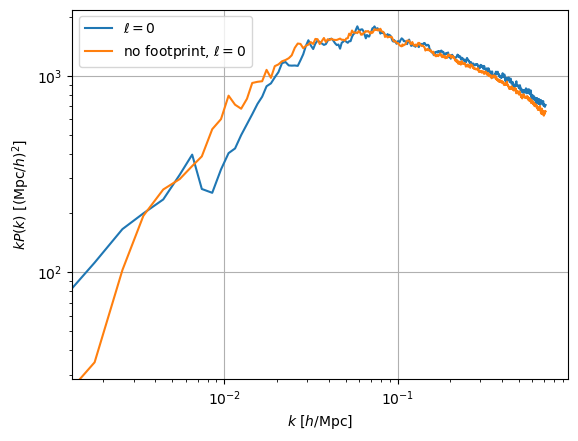

In [43]:
ax = plt.gca()
k,pk = poles(ell=ell, return_k=True, complex=False)
k_test,pk_test = poles_test(ell=ell, return_k=True, complex=False)
ax.plot(k, k*pk, label=f'$\ell = {ell}$')
ax.plot(k_test, k_test*pk_test, label=f'no footprint, $\ell = {ell}$')
ax.legend()
ax.grid(True)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$kP(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

Shot noise is 7409.7001.
Normalization is 117.7957.


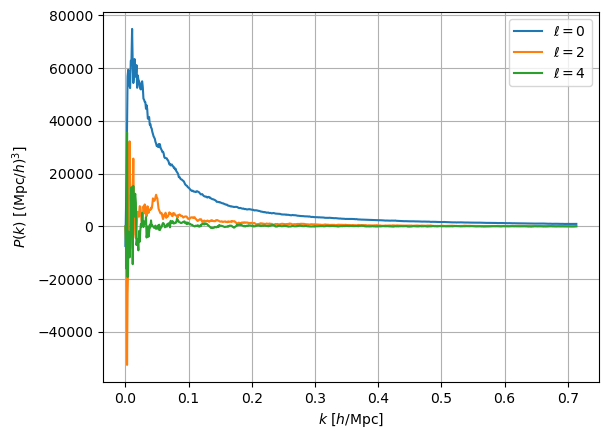

In [23]:
poles = result.poles
print('Shot noise is {:.4f}.'.format(poles.shotnoise)) # cross-correlation, shot noise is 0.
print('Normalization is {:.4f}.'.format(poles.wnorm))
ax = plt.gca()
for ill, ell in enumerate(poles.ells):
    # Calling poles() removes shotnoise for ell == 0 by default;
    # Pass remove_shotnoise = False if you do not want to;
    # See get_power() for all arguments
    ax.plot(*poles(ell=ell, return_k=True, complex=False), label=r'$\ell = {:d}$'.format(ell))
ax.legend()
ax.grid(True)
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.show()

In [24]:
d = fitsio.read(f"/pscratch/sd/a/arosado/mocks_tests/data_2.3_1024_1.fits")
r = fitsio.read(f"/pscratch/sd/a/arosado/mocks_tests/randoms_2.3_1024_1.fits")

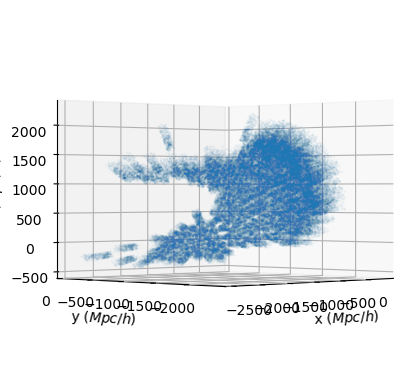

In [36]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xd = d['Position'][:,0]
yd = d['Position'][:,1]
zd = d['Position'][:,2]

ax.scatter(xd, yd, zd, marker='.',s=0.2, alpha=0.05)

ax.set_xlabel('x ($Mpc/h$)')
ax.set_ylabel('y ($Mpc/h$)')
ax.set_zlabel('z ($Mpc/h$)')
#ax.set_xlim(xd.min(), xd.max())
#ax.set_ylim(yd.min(), yd.max())
#ax.set_zlim(zd.min(), zd.max())
ax.view_init(180,45,180)
plt.show()

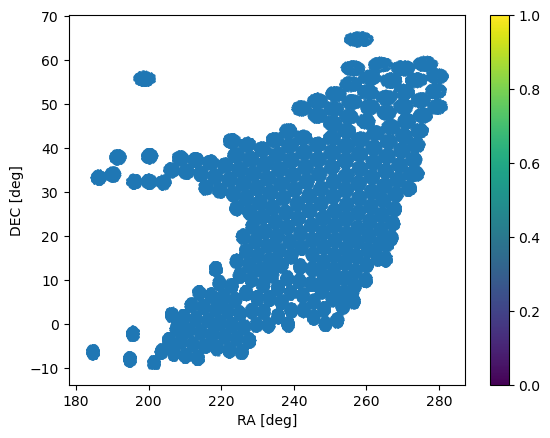

In [26]:
ra,dec = d['RA'], d['DEC']


sc = plt.scatter(ra,dec,s=0.2)
#sc = plt.scatter(ra,dec,c=sys,s=0.2)
plt.colorbar(sc)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.show()

4.03105025181677
0.0 20.155251259083848


Text(0, 0.5, 'DEC [deg]')

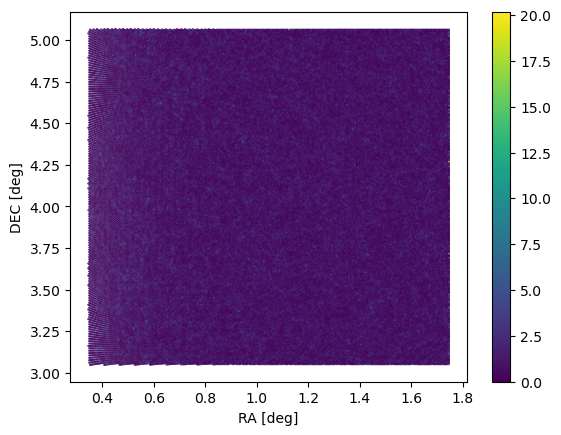

In [39]:
import healpy as hp
def hpixsum(nside, ra, dec, weights=None):
    hpix = hp.ang2pix(nside, np.radians(90 - dec), np.radians(ra))
    npix = hp.nside2npix(nside)
    weight_hp = np.bincount(hpix, weights=weights, minlength=npix)
    return weight_hp

nside = 256
data_hpmap = hpixsum(nside,d['RA'],d['DEC'])
rands_hpmap = hpixsum(nside,r['RA'],r['DEC'])
mask = rands_hpmap > 0.
hpix = np.argwhere(mask)
#hpix = hp.ang2pix(nside, np.radians(90 - r['DEC'][mask]), np.radians(r['RA'][mask]))
d_ = data_hpmap[mask]
r_ = rands_hpmap[mask]


norm = r_.sum()/d_.sum()
print(norm)
dens = d_/r_
dens_norm = dens * norm
print(dens_norm.min(), dens_norm.max())
ra,dec = hp.pixelfunc.pix2ang(nside, hpix)

sc = plt.scatter(ra,dec,c=dens_norm,s=0.2)
plt.colorbar(sc)
plt.xlabel("RA [deg]")
plt.ylabel("DEC [deg]")

In [44]:
d_.min()

0

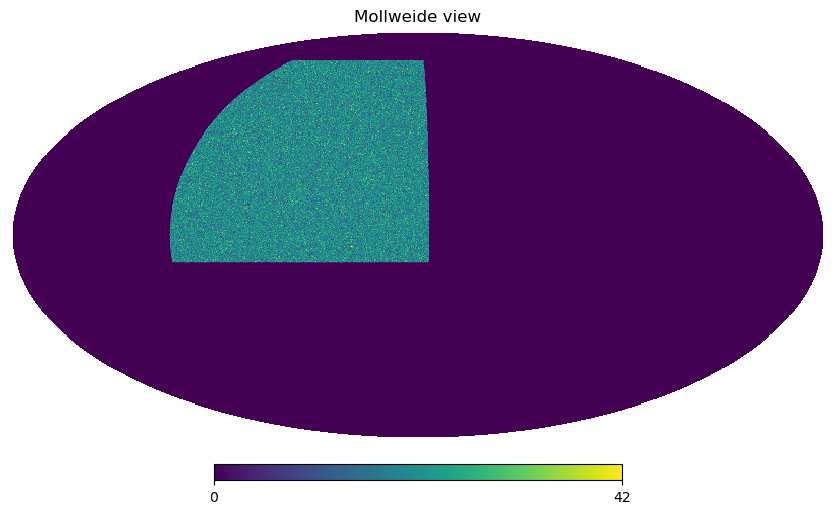

In [40]:
hp.mollview(rands_hpmap, rot=180)

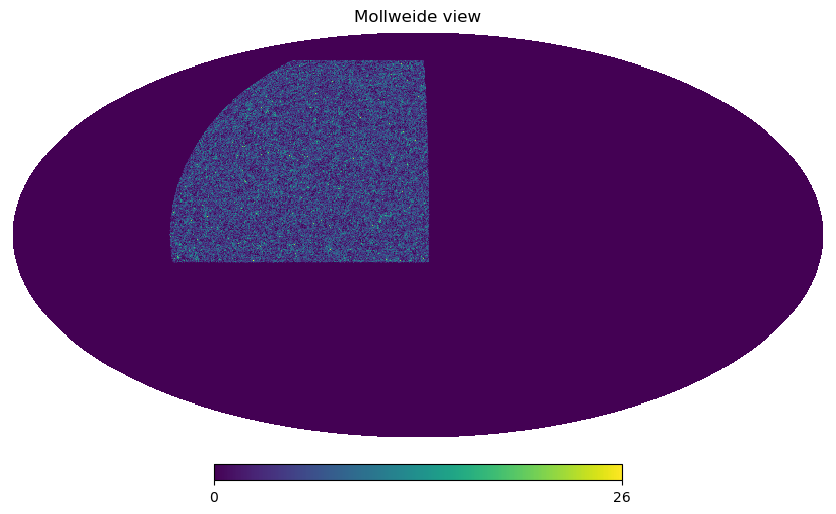

In [32]:
hp.mollview(data_hpmap, rot=180)

In [22]:
# survey cats
tracer = 'ELG_LOPnotqso'
iron_dir = '/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0/'
data_fn = os.path.join(iron_dir, f'{tracer}_full.dat.fits')
randoms_fn = os.path.join(iron_dir, f'{tracer}_0_full.ran.fits')
d_cat = fitsio.read(data_fn)

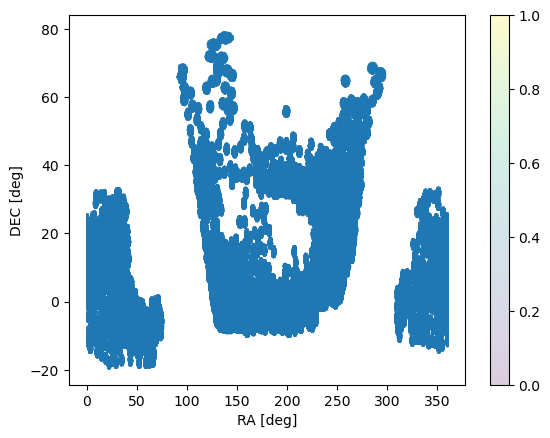

In [23]:
ra,dec = d_cat['RA'], d_cat['DEC']

sc = plt.scatter(ra,dec,s=0.2,alpha=0.2)
#sc = plt.scatter(ra,dec,c=sys,s=0.2)
plt.colorbar(sc)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.show()

In [11]:
d

array([([  650.47112269, -1804.25426386,  -334.26146402], [-1.430904  ,  3.22153809, -2.99609192], 289.82528617, -9.88635986, 1946.83765539, 0.8055231 ),
       ([  652.36622208, -1803.08542439,  -330.79439104], [-2.08559457,  3.70469041, -3.48486137], 289.89040248, -9.78808803, 1945.7964088 , 0.80496957),
       ([  654.45528035, -1804.57399159,  -328.61460193], [-5.42764344,  3.1476568 , -3.47713133], 289.93392069, -9.71433344, 1947.50778219, 0.80587944),
       ...,
       ([-1359.68207502, -1597.57383769,  1259.4201845 ], [ 6.03673657,  3.02702737, -2.2657623 ], 229.59916458, 30.9780081 , 2446.85853966, 1.09511337),
       ([-1359.92551145, -1622.59881314,  1239.57680671], [ 2.69229038,  4.09379019, -0.14441861], 230.0330989 , 30.34895862, 2453.31917304, 1.09919852),
       ([-1356.41979596, -1690.43508189,  1144.61765178], [ 0.73460691,  5.53686875, -5.3866657 ], 231.25613956, 27.83926425, 2451.0395749 , 1.09775599)],
      dtype=[('Position', '>f8', (3,)), ('Displacement', '>f8',

In [18]:
d['Position'][:,0]

array([  650.47112269,   652.36622208,   654.45528035, ...,
       -1359.68207502, -1359.92551145, -1356.41979596])

In [17]:
699338*3

2098014